In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.utils import resample
from tqdm import tqdm

Load the data

In [139]:
bac = pd.read_csv('data/ecs171.dataset.txt', sep = '\s+' )
print(bac.shape)
bac.head()

(194, 4502)


,ID,Strain,Medium,Stress,GenePerturbed,GrowthRate,b3356,b2922,b2519,b3823,...,b4684,b4689,b4685,b4683,b4682,b4699,b4698,b4704,b4703,b4635
0,T8129,MG1655,MD001,none,oxyR_KO,0.637,0.304790,0.506615,0.289473,0.289473,...,0,0,0,0,0,0,0,0,0,NaN
1,T8130,MG1655,MD001,none,oxyR_KO,0.637,0.361095,0.582885,0.259295,0.259295,...,0,0,0,0,0,0,0,0,0,8
2,T8131,MG1655,MD001,none,oxyR_KO,0.637,0.295920,0.477482,0.304459,0.304459,...,0,0,0,0,0,0,0,0,0,
3,T8135,MG1655,MD001,none,soxS_KO,0.724,0.332041,0.554672,0.308533,0.308533,...,0,0,0,0,0,0,0,0,0,0
4,T8136,MG1655,MD001,none,soxS_KO,0.724,0.323373,0.442617,0.318442,0.318442,...,0,0,0,0,0,0,0,0,0,NaN


Notice the last column does not always have any value, so I decided to drop it. And since there are more than 4000 attributes, and base on the basic knowledge of the gene, it should not make too much difference.

In [140]:
bac.drop(columns = 'b4635', axis = 1, inplace = True)

In [141]:
y = bac.GrowthRate
x = bac.iloc[:,6: ]
x.head()

,b3356,b2922,b2519,b3823,b3824,b3353,b1500,b2923,b2513,b2512,...,b4673,b4684,b4689,b4685,b4683,b4682,b4699,b4698,b4704,b4703
0,0.304790,0.506615,0.289473,0.289473,0.092213,0.109991,0.289473,0.289473,0.316641,0.248555,...,0,0,0,0,0,0,0,0,0,0
1,0.361095,0.582885,0.259295,0.259295,0.104293,0.149100,0.259295,0.259295,0.350822,0.256931,...,0,0,0,0,0,0,0,0,0,0
2,0.295920,0.477482,0.304459,0.304459,0.084021,0.121631,0.304459,0.304459,0.333197,0.251729,...,0,0,0,0,0,0,0,0,0,0
3,0.332041,0.554672,0.308533,0.308533,0.109976,0.146904,0.308533,0.308533,0.318897,0.267445,...,0,0,0,0,0,0,0,0,0,0
4,0.323373,0.442617,0.318442,0.318442,0.109609,0.128908,0.318442,0.318442,0.293445,0.253606,...,0,0,0,0,0,0,0,0,0,0


## 1. Elastic Net with Cross-Vlaidation:

In [142]:
class myEnet():
    '''
    define my elastic class, so it would be easier to extend any method or requirments.
    This class will tune the prameter by using cross validation.
    The model this class will return is Elastic net.
    To deploy cross-validation, ElasticNetCV function that built in sklearn.linear_model will be used.
    '''

    def __init__(self, **kw):
        '''
        Pass any keywords required in ElatisticNetCV.
        '''
        self._model = ElasticNetCV(**kw)
    
    def __call__(self, x, y):
        '''
        Call the method of the elastic model by calling the object itself.
        '''

        self._model.fit(x, y)
        return self._model

    def get_scores(self):
        '''
        Get the average mse under each combination of l1_ratio and alpha.
        Return a pandas dataframe.  
        '''
        parameters = self._model.get_params()
        l1_ratio = parameters['l1_ratio']
        alphas = parameters['alphas']
        mse = self._model.mse_path_
        mean_mse = np.mean(mse, axis = 2)
        frame = pd.DataFrame(mean_mse, index = l1_ratio, columns = alphas)
        frame.index.names = ["l1_ratio"]
        frame.columns.names = ['alpha']
        return frame

    def get_best_model(self):
        '''
        Based on best parameters tuned by cross validation, get the best model.
        This method requires sklearn.linear_model.ElasticNet being imported.
        Return a model that has not been fitted.
        '''
        alpha = self._model.alpha_
        l1_ratio = self._model.l1_ratio_
        return ElasticNet(alpha = alpha, l1_ratio = l1_ratio)

    def get_n_attributes(self):
        '''
        Get the number of attributes that is informative which means in the model, the coefficient of the corresponding attribute is not 0
        '''

        return sum(self._model.coef_ != 0)

    def get_index_attributes(self):
        '''
        Get the indices of the informative attributes.
        '''
        return list(np.where(self._model.coef_ != 0)[0])

    def bootstrapPred(self,x, y, x_pred, n_samples = 1000, alpha = 0.05, iters = 100)-> list:
        '''
        Params:
        x: Training set for x
        y: Training set for y
        x_pred: The target to be predicted
        alpha: confidence level
        n_samples: number of resample data size
        iters: number of resamples

        Return:
        The confidence interval for given data to be predicted under given alpha which is the confidence level.
        '''
        model = self.get_best_model()
        pred = []

        for i in tqdm(range(iters)):
            # resample the data, fit the model, and get the prediction.
            x_strapped, y_strapped = resample(x, y, n_samples = n_samples)
            model.fit(x_strapped, y_strapped)
            y_pred = model.predict(x_pred)[0]
            pred.append(y_pred)
        # Sort the prediction and get the empirical quantile
        pred.sort()
        lb = int(iters * (alpha / 2))
        rb = int(iters * (1 - alpha / 2))

        return pred[lb], pred[rb]
    


In [143]:
# Tuning the parameters. 
# l1 ratio: .1, .25, .5, .75, .9, 1
# Numbers of alpha = 6
# There are 30 combinations in total.
enet = myEnet(cv = 5, n_jobs = -1, random_state = 256, l1_ratio = [ .1, .25, .5, .75, .9, 1], alphas = [0.5, 1, 2, 4, 8, 16], max_iter = 8000, verbose = True)
model = enet(x, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
....................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


In [144]:
enet.get_scores()

alpha,0.5,1.0,2.0,4.0,8.0,16.0
l1_ratio,,,,,,
0.10,0.055702,0.055702,0.055771,0.055743,0.053729,0.056487
0.25,0.055702,0.055702,0.055702,0.055779,0.055749,0.054794
0.50,0.055702,0.055702,0.055702,0.055702,0.055779,0.055749
0.75,0.055702,0.055702,0.055702,0.055702,0.055702,0.055768
0.90,0.055702,0.055702,0.055702,0.055702,0.055702,0.055782
1.00,0.055702,0.055702,0.055702,0.055702,0.055702,0.055779


As the score table shows, the minimal mse is obtained when alpha = 8 and l1_ratio = 0.1.

In [145]:
enet.get_n_attributes()

8

In [146]:
enet.get_index_attributes()

[152, 159, 400, 723, 2409, 2576, 2718, 3088]

In [147]:
model.alpha_

1.0

In [148]:
model.l1_ratio_

0.1

Based on the output above, when set alpha = 8 and l1_ratio to be .1, there will be 8 attributes that are treated as informative in the model, and their indices are: 152,  159,  400,  723, 2409, 2576, 2718, 3088. And the five-fold cross validation error is 0.053729.

## 2. Bootstrap method.

### Assumption:
The empirical quantile obtained by bottstrap can actually refelct the theoritical qunatiles.

### Methodolodgy:


## 3. Using boptstrap method giving the confidence interval for predcition.

In [149]:
# Calculate the average expression value of each gene.
x_pred = np.array(np.mean(x, axis = 0)).reshape(1,-1)
x_pred

array([[0.25816219, 0.15967946, 0.07014185, ..., 0.        , 0.        ,
        0.        ]])

In [150]:
# Predict a bactarium that has the average expression value.
# Set the confidence level to be 0.95
confidence_interval = enet.bootstrapPred(x = x, y = y, x_pred = x_pred, alpha = 0.05, iters = 1000, n_samples = 100)

100%|██████████| 1000/1000 [00:13<00:00, 72.03it/s]


In [151]:
confidence_interval

(0.3511215697626844, 0.4343200725733349)

So under confidence level to be 0.95, total number of resample to be 1,000, and size of the sample size to be 100, I got the confidence interval as above:

(0.35264363973876534, 0.43909991206866344)

## 4. SVM models 

Build 4 classifiers to indentify strain type, medium type, environmental and gene perturbatio.

In [195]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [153]:
## The four dependent variables to be predicted.
strain = bac.Strain
medium = bac.Medium
evrn  = bac.Stress
gene = bac.GenePerturbed

Based on the analysis above in Elastic Net section, the output shows that not all the attributes are neccessarily informative. So I will just use the 8 attributes that chosen by the best elastic net model. So for all the 4 models, I will use the same 8 features.

In [154]:
# Get the eight predictors.
x_compressed = np.asarray(x.iloc[:, list(enet.get_index_attributes())])
x_compressed[1:3, :]

array([[0.25929457, 0.25929457, 0.25929457, 0.60116867, 0.25929457,
        0.10465893, 0.25929457, 0.25929457],
       [0.30445856, 0.30445856, 0.30445856, 0.41611775, 0.30445856,
        0.0893026 , 0.30445856, 0.30445856]])

In [291]:
# Create the four SVM classifiers..
smodel = svm.SVC(gamma = 'auto', random_state = 256, probability=True)
mmodel = svm.SVC(gamma = 'auto', random_state = 256, probability=True)
emodel = svm.SVC(gamma = 'auto', random_state = 256, probability=True)
gmodel = svm.SVC(gamma = 'auto', random_state = 256, probability=True)

# # Fit the models using corresponding response.
# for model, yy in zip([smodel, mmodel, emodel, gmodel], [strain, medium, evrn, gene]):
#     model.fit(x_compressed, yy)    
#     print(model)

After building the models, to assess the models it is required to use ROC curve and AUC score. But the problem to be solved is that typically, ROC curve is designed for a binary model that is the dependent variable should only have 2 classes. But in this problem, as we can see, all the 4 variables have multiple classes. And micro-average ROC curve is suitable here.

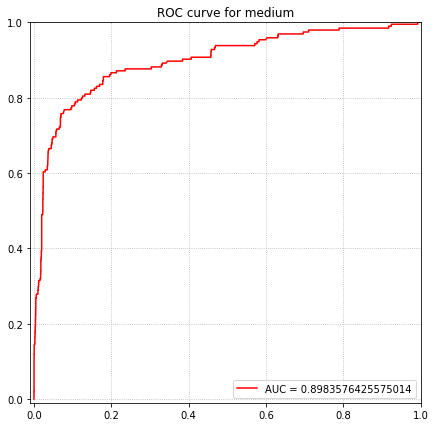

In [292]:
from sklearn.preprocessing import label_binarize
medium_bi = label_binarize(medium, classes = np.unique(medium))
mmodel.fit(x_compressed, medium)
medium_scores = mmodel.predict_proba(x_compressed)
fpr, tpr, threshold = roc_curve(medium_bi.ravel(), medium_scores.ravel())
auc_ = auc(fpr, tpr)
auc_
## Visualize the ROC curve
plt.figure(figsize= (7,7))
plt.plot(fpr, tpr, 'r', label = 'AUC = {}'.format(auc_))
plt.xlim((-.01, 1))
plt.ylim((-.01,1))
plt.grid(b = True, ls = ':')
plt.legend(loc = 'lower right')
plt.title('ROC curve for {}'.format('medium'))
plt.show()

In [337]:
def cvRoc(clf, y, folds = 5, unbalanced = True):
    '''
    Function that evaluate SVM models using ROC and AUC obtained by cross validation.
    sklearn.model_selection.StratifiedKFold is required.
    Inputs:
    :: model: SVM model to be evaluated
    :: y    : Dependent variable to fit on. Should be already binarized.

    Return:
    The ROC curve plot and its AUC score.

    '''
    cv = StratifiedKFold(n_splits = folds, random_state = 1)
    fprs = [] 
    tprs = []
    aucs = []
    i = 0
    if unbalanced:
        y = y.repeat(2*folds)
        x = x_compressed.repeat(2*folds, axis = 0)
    else:
        x = x_compressed

    plt.figure(figsize= (7,7))    
    for train, test in cv.split(x, y):
        i += 1
        clf.fit(x[train], y[train])
        probas_ = clf.predict_proba(x[test])
        test_bi = label_binarize(y[test], classes = np.unique(y)).ravel()
        fpr, tpr, threshold = roc_curve(test_bi, probas_.ravel())
        fprs.append(fpr)
        tprs.append(tpr)
        auc_ = auc(fpr, tpr)

        # Plot the ROC curve:
        plt.plot(fpr, tpr, alpha = 0.3, label = '%d th ROC, AUC = %.2f'%(i, auc_))

    plt.title('ROC curve for {}'.format('medium'))    
    plt.legend()
    plt.show()


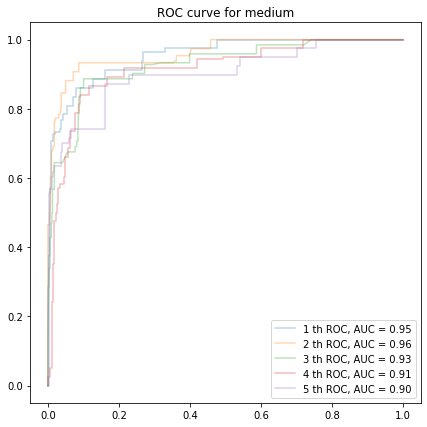

In [338]:
cvRoc(smodel, np.array(strain), folds = 5)

In [335]:
mmodel.fit(x, medium)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=256, shrinking=True, tol=0.001,
    verbose=False)